# Job Shop Scheduling Problem

The job shop scheduling problem is a classic problem in combinatorial optimization. It is a generalization of the [flow shop scheduling problem](https://en.wikipedia.org/wiki/Flow_shop_scheduling) where each job consists of a sequence of tasks that must be performed on a set of machines. Each task must be performed on a specific machine, no two tasks can be performed simultaneously on the same machine and every task must run to completion after it has started. The goal is to find a schedule that minimizes the makespan, i.e., the time at which all jobs have been completed.

<img src="img/jobshop-scheduling.png" alt="Solved jobshop-scheduling" style="width:600px; height:400px;">

In this notebook, we will model and solve an instance of the job shop scheduling problem using SeaPearl.jl.



## Setup
We will begin by activating the environment and importing the necessary packages.

In [40]:
using Revise
using Pkg
Pkg.activate("../../../")
using SeaPearl

  Activating project at `c:\Users\leobo\Desktop\École\Poly\SeaPearl\SeaPearlZoo.jl`


## Problem formulation

The instances have the following format:
```
3 3 500

23 54 19
45 74 34
63 73 55

2 1 0
0 2 1
1 2 0
```
The instances contain **3 blocks**:
- The first block (first line) contains the number of machines, the number of jobs and the maximum time. 
- The second block contains the duration of each task on each machine. For example, the first line of this block indicates that task 1 takes 23 time units on machine 1, task 2 takes 54 time units on machine 2 and task 3 takes 19 time units on machine 3. 
- The third block contains the order in which the machines must be visited for each job. For example, the first line of this block indicates that job 1 must be performed in the order: machine 3, machine 2 and machine 1.

## Parsing the Instances

We will now build utilities to parse the instances.

In [41]:
"""JobshopInputData(numberOfMachines::Int, numberOfJobs::Int, maxTime::Int, job_times::Matrix{Int}, job_order::Matrix{Int})
Contains the input data for the jobshop problem
"""
struct JobshopInputData
    numberOfMachines::Int
    numberOfJobs::Int
    maxTime::Int
    job_times::Matrix{Int}
    job_order::Matrix{Int}
end


"""parseJobshopInput(filename::String)
Parse the input file of the jobshop problem
Args:
    filename::String: path to the file to parse
Returns:
    ::JobshopInputData: Job Shop scheduling problem input data
"""
function parseJobshopInput(filename::String)
    raw_input = nothing
    open(filename, "r") do openedFile
        raw_input = read(openedFile, String)
    end
    
    lines = split(raw_input, '\n')
    firstLine = split(lines[1], ' ')

    numberOfMachines = parse(Int, firstLine[1])
    numberOfJobs = parse(Int, firstLine[2])
    maxTime = parse(Int, firstLine[3])

    job_times = Matrix{Int}(undef, numberOfJobs, numberOfMachines)
    job_order = Matrix{Int}(undef, numberOfJobs, numberOfMachines)

    for i in 1:numberOfJobs
        durations = split(lines[i+2], ' ')
        orders = split(lines[i+3+numberOfJobs], ' ')
        job_times[i, :] = map(x -> parse(Int, x), durations)
        job_order[i, :] = map(x -> parse(Int, x), orders)
    end

    return JobshopInputData(numberOfMachines, numberOfJobs, maxTime, job_times, job_order)
end

parseJobshopInput

In [42]:
jobshop_input = parseJobshopInput("./data/js_3_3")

JobshopInputData(3, 3, 500, [23 54 19; 45 74 34; 63 73 55], [2 1 0; 0 2 1; 1 2 0])

## Modeling the Problem

We will now build a model for the problem

In [43]:
numberOfMachines = jobshop_input.numberOfMachines
numberOfJobs = jobshop_input.numberOfJobs
maxTime = jobshop_input.maxTime
job_times = jobshop_input.job_times
job_order = jobshop_input.job_order

trailer = SeaPearl.Trailer()
model = SeaPearl.CPModel(trailer)
model.adhocInfo = Dict("numberOfMachines" => numberOfMachines, "numberOfJobs" => numberOfJobs)

### Variable declaration ###    

# Start/End times for each machine and jobs
job_start = Matrix{SeaPearl.AbstractIntVar}(undef, numberOfJobs, numberOfMachines)
job_end = Matrix{SeaPearl.AbstractIntVar}(undef, numberOfJobs, numberOfMachines)

# add variables
for i in 1:numberOfJobs
    for j in 1:numberOfMachines
        job_start[i, j] = SeaPearl.IntVar(0, maxTime, "job_start_" * string(i) * "_" * string(j), model.trailer)
        SeaPearl.addVariable!(model, job_start[i, j]; branchable=true)
        job_end[i, j] = SeaPearl.IntVarViewOffset(job_start[i, j], job_times[i, j], "job_end_" * string(i) * "_" * string(j))
        SeaPearl.addVariable!(model, job_end[i, j]; branchable=false)
        # Set maxTime as upper bound to each job_end
        SeaPearl.addConstraint!(model, SeaPearl.LessOrEqualConstant(job_end[i, j], maxTime, trailer))
    end
end

## Makespan
makespan = SeaPearl.IntVar(0, maxTime, "makespan", model.trailer)
SeaPearl.addVariable!(model, makespan; branchable=false)
SeaPearl.addConstraint!(model, SeaPearl.MaximumConstraint(job_end, makespan, trailer))

### Constraints ###

# ensure non-overlaps of the jobs
for i in 1:numberOfJobs
    SeaPearl.addConstraint!(model, SeaPearl.Disjunctive(job_start[i, :], job_times[i, :], trailer))
end

# ensure non-overlaps of the machines
for i in 1:numberOfMachines
    SeaPearl.addConstraint!(model, SeaPearl.Disjunctive(job_start[:, i], job_times[:, i], trailer))
end

# ensure the job order
for job in 1:numberOfJobs
    for machine1 in 1:numberOfMachines
        for machine2 in 1:numberOfMachines
            if machine1 < machine2
                if job_order[job, machine1] < job_order[job, machine2]
                    SeaPearl.addConstraint!(model, SeaPearl.LessOrEqual(job_end[job, machine1], job_start[job, machine2], trailer))
                else
                    SeaPearl.addConstraint!(model, SeaPearl.LessOrEqual(job_end[job, machine2], job_start[job, machine1], trailer))
                end
            end
        end
    end
end

### Objective ###
SeaPearl.addObjective!(model, makespan)

### Solve ###
model.limit.searchingTime = 60

60

In [44]:
my_heuristic(x::SeaPearl.IntVar; cpmodel=nothing) = minimum(x.domain)
SeaPearl.solve!(model; variableHeuristic=SeaPearl.MinDomainVariableSelection{true}(), valueSelection=SeaPearl.BasicHeuristic(my_heuristic))

:TimeLimitStop

## Plotting the Solution

Now that we have a solution, we can plot it. We will first filter the solutions obtained to grab the best one, then we'll plot it with a Gantt chart.

In [45]:
function get_top_solution(model::SeaPearl.CPModel)
    top_solution = nothing
    top_makespan = nothing
    for solution in model.statistics.solutions
        if !isnothing(solution)
            if isnothing(top_solution)
                top_solution = solution
                top_makespan = solution["makespan"]
            elseif solution["makespan"] < top_makespan
                top_solution = solution
                top_makespan = solution["makespan"]
            end
        end
    end
    return top_solution
end

get_top_solution (generic function with 1 method)

In [46]:
solution = get_top_solution(model)

Dict{String, Union{Bool, Int64, Set{Int64}}} with 19 entries:
  "job_start_1_3" => 55
  "job_end_2_2"   => 275
  "job_end_3_1"   => 118
  "job_start_1_2" => 74
  "job_end_3_3"   => 55
  "job_end_1_2"   => 128
  "job_start_3_2" => 128
  "job_end_1_1"   => 151
  "job_end_2_3"   => 108
  "job_start_2_1" => 0
  "job_end_1_3"   => 74
  "job_start_3_3" => 0
  "job_start_3_1" => 55
  "job_start_2_2" => 201
  "job_start_1_1" => 128
  "job_end_3_2"   => 201
  "makespan"      => 275
  "job_start_2_3" => 74
  "job_end_2_1"   => 45

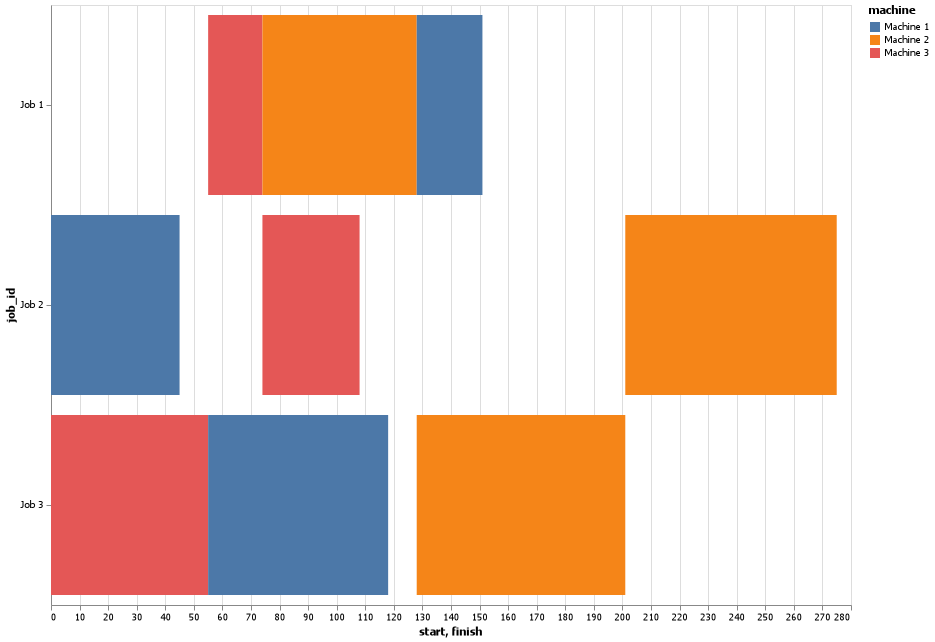

In [49]:
using VegaLite, DataFrames

df = DataFrame(job_id = String[], start = Int[], finish = Int[], machine = String[])

for (k, v) in solution
    if occursin("start", k)
        job_id, machine_id = split(k, "_")[3:4]
        end_time = solution["job_end_" * job_id * "_" * machine_id]
        push!(df, ["Job " * job_id, v, end_time, "Machine " * machine_id])
    end
end

df |> @vlplot(:bar, 
    x = "start:q", 
    x2 = "finish:q", 
    y = {"job_id:n", sort = "ascending"}, 
    color = "machine:n",
    width = 800, 
    height = 600)

